In [1]:
import os
import re
import pandas as pd
import numpy as np
from skimage import measure
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage import exposure, filters
from sklearn import metrics

2022-09-20 16:21:58.637183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# FUNCIONES

In [3]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask


def list_files(path):
    return [f for f in os.listdir(path) 
                if os.path.isfile(os.path.join(path, f))]

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


mask_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mascaras/mask_1.h5', 
                                    custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})
sub_mask = keras.Model(inputs=mask_model.input, outputs=mask_model.layers[18].output)
sub_mask.trainable = False


def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return 0.6*abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + loss2
    return loss


model_mask = os.path.join('/home/mr1142/Documents/Data/models/mascaras/unet_final_renacimiento_validation_6.h5')
model_mask = keras.models.load_model(model_mask, 
                                    custom_objects={"MyLoss": MyLoss, 
                                                    "loss_mask": loss_mask, 
                                                    "dice_coef_loss": dice_coef_loss,
                                                    "dice_coef": dice_coef})


def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 2)
    img = np.uint8(img)
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def get_prepared_img(img, pix, mask = True, clahe_bool = False, equalize_bool = False):
    if mask:
        img = des_normalize(apply_mask(img, model_mask))
    img = recolor_resize(img, pix)
    if clahe_bool:
        img = clahe(img)
    if equalize_bool:
        img = equalize(img)
    img = normalize(img)
    return img

2022-09-20 16:22:01.441157: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 16:22:01.441849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-20 16:22:01.483844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-20 16:22:01.483879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-20 16:22:01.485693: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-20 16:22:01.485732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [4]:
def custom_binary_loss(y_true, y_pred): 
    # https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/backend.py#L4826
    y_true = K.cast(y_true, 'float32')
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  # Cancels out when target is 1 
    term_1 = y_true * K.log(y_pred + K.epsilon()) # Cancels out when target is 0
    suma = term_0 + term_1
    return -K.mean(suma, axis=1)+K.std(suma, axis = 1)

In [5]:
def AUC_plot(fpr, tpr, thresholds, auc):
    fig, ax = plt.subplots()
    i = np.argmax(tpr-fpr)
    th = thresholds[i]
    x = fpr[i]
    y = tpr[i]
    ax.plot(fpr,tpr, "g-", label="AUC="+str(round(auc, 2)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    try:
        ax.plot([x, x], [0, y], "r:")
        ax.plot([0, x], [y, y], "r:")
    except:
        print('plot except')
    ax.plot([x], [y], "ro", label="th="+str(round(th,2))) 
    ax.legend(loc=4)
    return fig

# CARGAR DATOS

**PEDIATRIC**

In [6]:
def create_dataframe(folder, path = '/home/mr1142/Documents/Data/chest_xray'):
    path = os.path.join('/home/mr1142/Documents/Data/chest_xray', folder)
    for fold in os.listdir(path):
        globals()[fold] = {}
        imgs = os.listdir(os.path.join(path, fold))
        globals()[fold]['path'] = [os.path.join(path, fold)] * len(imgs)
        globals()[fold]['img_name'] = imgs
        globals()[fold]['normal'] = [1 if fold == 'NORMAL' else 0 for _ in range(len(imgs))]
        globals()[fold]['viral'] = [1 if re.search('virus', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['bacteria'] = [1 if re.search('bacteria', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['real'] = [0 if fold == 'NORMAL' else 1 if re.search('virus', imgs[i]) else 2 for i in range(len(imgs))]

    for k, v in PNEUMONIA.items():
        v.extend(NORMAL[k])

    df = pd.DataFrame(PNEUMONIA)

    return df

In [7]:
ped = create_dataframe('train')

**COVID**

In [8]:
path = '/home/mr1142/Documents/Data/neumonia_covid/all'
covid = pd.read_csv('/home/mr1142/Documents/Data/neumonia_covid/dataframe.csv')

In [9]:
covid = covid[covid['class'] != 'covid'].reset_index(drop = True)
covid['class'][covid['class'] == 'pneumonia'] = 1
covid['class'][covid['class'] == 'covid'] = 1
covid['class'][covid['class'] == 'normal'] = 0

**Cruces**

In [10]:
path_cruces = '/home/mr1142/Documents/Data/prueba_cruces'
imgs = os.listdir(path_cruces)

In [11]:
imgs = [im for im in imgs if not re.search('POST', im)]
true = [1 if re.search('NEUMO', im) else 0 for im in imgs]

In [12]:
pred = [neumonia_model.predict(np.expand_dims(get_prepared_img(cv2.imread(os.path.join(path_cruces, im)),pixels,mask = False, clahe_bool = True), axis = 0)) for im in imgs]

NameError: name 'neumonia_model' is not defined

In [ ]:
pred = np.vstack(pred)
fpr, tpr, auc_thresholds = metrics.roc_curve(true, pred[:,2])

# CARGAR MODELO

In [16]:
model_path = '/home/mr1142/Documents/Data/models/neumonia/completo_Xception_fine-05_batch-8_lr-0001_auc-99.h5'
neumonia_model = tf.keras.models.load_model(model_path)

# AUC

In [22]:
print(len(ped))
print(len(covid))

5216
3050


In [23]:
data = 'ped'
n = 5216

In [24]:
pixels = 512

In [25]:
if data == 'ped':
    df = ped
    subset = df.iloc[:n]
    imgs = [os.path.join(subset.path[i], subset.img_name[i]) for i in subset.index]
    true = list(subset['normal'])
elif data == 'covid':
    df = covid
    subset = df.iloc[:n]
    imgs = [os.path.join(path, subset.img_name[i]) for i in subset.index]
    true = list(subset['class'])

In [126]:
pred = [neumonia_model.predict(np.expand_dims(get_prepared_img(cv2.imread(im),pixels,mask = False, clahe_bool = True), axis = 0)) for im in imgs]

- Calculo de AUC respecto a normal o neumo

In [127]:
pred = np.vstack(pred)

In [128]:
if data == 'ped':
    tpr, fpr, auc_thresholds = metrics.roc_curve(true, pred[:,2])
elif data == 'covid':
    fpr, tpr, auc_thresholds = metrics.roc_curve(true, pred[:,2])

In [129]:
auc = metrics.auc(fpr, tpr)

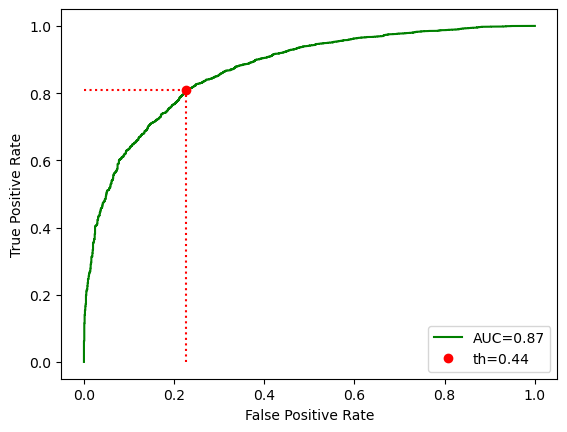

In [130]:
a = AUC_plot(fpr,tpr,auc_thresholds,auc)

In [131]:
true = np.array(true)
print(sum(true == 0))
print(sum(true == 1))

3875
1341


# SHAP

In [ ]:
import json
import numpy as np
import tensorflow as tf
import shap
import pickle
import h5py as f


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math

class DataGenerator(Sequence):
    
    def __init__(self, x_set, y_set, batch_size, pix, index, mask= False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.pix = pix
        self.index = index
        self.mask = mask

    def __len__(self):
        # numero de batches
        return math.ceil(len(self.index) / self.batch_size)

    def __getitem__(self, idx):
        # idx: numero de batch
        # batch 0: idx = 0 -> [0*batch_size:1*batch_size]
        # batch 1: idx = 1 -> [1*batch_size:2*batch_size]
        # Lo que hago es recorrer el indice
        index = self.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        index.sort()
        temp_x = self.x[index]
        batch_y = self.y[index]
        batch_x = np.zeros((temp_x.shape[0], self.pix, self.pix, 1))
        for i in range(temp_x.shape[0]):
            try:
                batch_x[i] = get_prepared_img(temp_x[i], self.pix, self.mask)
            except:
                img = np.random.randint(0,255,self.pix*self.pix).reshape((self.pix, self.pix, 1))
                batch_x[i] = normalize(img)
                print('e')
        return np.array(batch_x), np.array(batch_y)

In [ ]:
def generate_index(subset_bool = False, trainprop = 0.8):
    if subset_bool:
        with open("/home/mr1142/Documents/img_class/indices/train_subset", "rb") as fp:
            index = pickle.load(fp)
    else:
        with open("/home/mr1142/Documents/img_class/indices/train", "rb") as fp:
            index = pickle.load(fp)

    np.random.shuffle(index)
    idtrain = index[:int(len(index)*trainprop)]
    idtest = index[int(len(index)*trainprop):]

    return idtrain, idtest

In [ ]:
# DATAFRAME
df = f.File("/home/rs117/covid-19/data/cxr_consensus_dataset_nocompr.h5", "r")
for key in df.keys():
    globals()[key] = df[key]

# DATA GENERATORS
idtrain, idtest = generate_index()
# np.random.shuffle(idtrain)
# np.random.shuffle(idtest)
# idtrain = idtrain[0:5000]
# idtest = idtest[0:5000]

In [ ]:
traingen = DataGenerator(X_train, y_train, 8, pixels, idtrain)
testgen = DataGenerator(X_train, y_train, 8, pixels, idtest)

In [ ]:
y_train = y_train[idtrain]

In [ ]:
# ims = [get_prepared_img(cv2.imread(im),pixels,mask = False, clahe_bool = True) for im in imgs[0:10]]

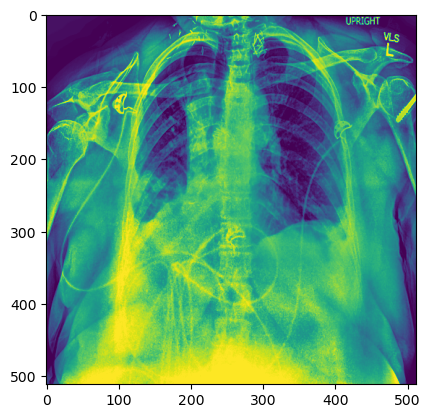

In [ ]:
plt.imshow(traingen[6][0][5])

In [ ]:
def f(x):
    tmp = x.copy()
    return neumonia_model(tmp)

# define a masker that is used to mask out partitions of the input image. 
masker = shap.maskers.Image("inpaint_telea", traingen[0][0][0].shape)

# create an explainer with model and image masker 
explainer = shap.Explainer(f, masker, output_names=['normal', 'moderado', 'severo'])

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(traingen[6][0][5:6], max_evals=5000, batch_size=8, outputs=shap.Explanation.argsort.flip[:3]) 


100%|███████████████████████████████████████████████████████████▉| 4994/4998 [09:30<00:00,  8.59it/s]
5002it [09:31,  8.52it/s]                                                                            
5006it [09:32,  8.57it/s]
                         
Partition explainer: 2it [09:38, 578.10s/it]                                                         


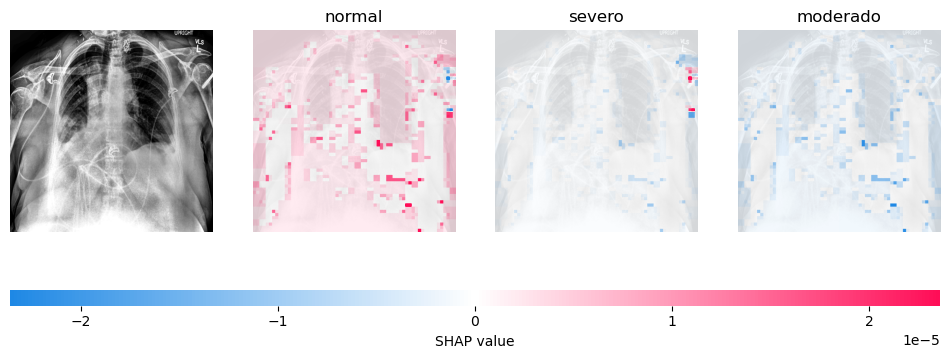

In [ ]:
shap.image_plot(shap_values)

In [ ]:
ims = traingen[0][0][0:2]
test = testgen[0][0][0:2]